<a href="https://colab.research.google.com/github/supernaiter/SSL_for_fine_grained_gesture_recognition/blob/main/20230221_TS2Vec%E3%82%92%E4%BD%BF%E3%81%A3%E3%81%9Fgesture_classification%E3%81%AE%E3%83%8F%E3%83%B3%E3%82%BA%E3%82%AA%E3%83%B3%E9%85%8D%E5%B8%83%E7%94%A8_written_by_naoki_kimura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self-Supervised Approach for Few-shot Hand Gesture Recognitionを追実装する（本人）ハンズオンノートブック．
https://dl.acm.org/doi/abs/10.1145/3526114.3558707



> 多次元時系列データの教師なし表現学習ができるTS2Vec(https://github.com/yuezhihan/ts2vec)を使って，Apple Watchによるfine-grained gesture認識を行う．一つのクラスにつきわずか5-10個のサンプルで95%以上のaccuracyを達成する．
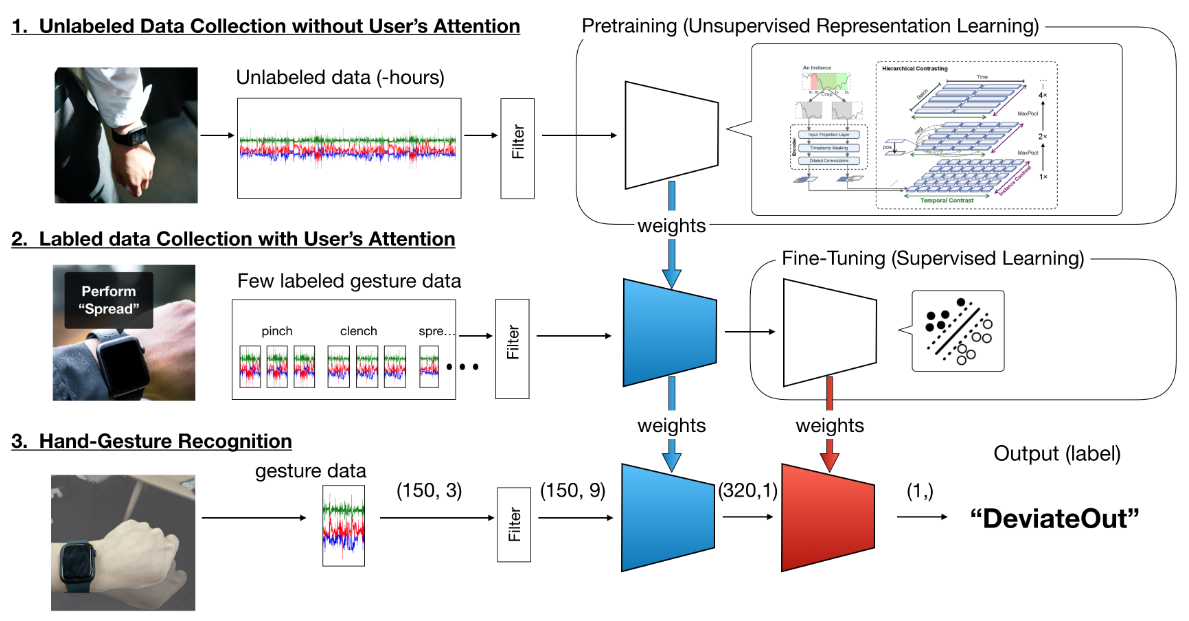

Data-driven machine learning approaches have become increasingly used in human-computer interaction (HCI) tasks. However, compared with traditional machine learning tasks, for which large datasets are available and maintained, each HCI project needs to collect new datasets because HCI systems usually propose new sensing or use cases. Such datasets tend to be lacking in amount and lead to low performance or place a burden on participants in user studies. In this paper, taking hand gesture recognition using wrist-worn devices as a typical HCI task, I propose a self-supervised approach that achieves high performance with little burden on the user. The experimental results showed that hand gesture recognition was achieved with a very small number of labeled training samples (five samples with 95% accuracy for 5 gestures and 10 samples with 95% accuracy for 10 gestures). The results support the story that when the user wants to design 5 new gestures, he/she can activate the feature in less than 2 minutes. I discuss the potential of this self-supervised framework for the HCI community.


・TS2Vec
https://github.com/yuezhihan/ts2vec.
https://ar5iv.labs.arxiv.org/html/2106.10466


In [1]:
!pip install --upgrade --no-cache-dir gdown
!gdown "https://drive.google.com/uc?export=download&id=1Y5yqrpLmSdDvjed2JoNfJNSoGU7TcycZ"
!gdown "https://drive.google.com/uc?export=download&id=1dY0DlPiLECBws6iikZlDvLMx2SEcyad1"
!unzip "230105_apple_watch_unlabeled_9axis_for_ts2vec.npy.zip"

!git clone https://github.com/yuezhihan/ts2vec.git
%cd ts2vec
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
Downloading...
From: https://drive.google.com/uc?export=download&id=1Y5yqrpLmSdDvjed2JoNfJNSoGU7TcycZ
To: /content/230105_apple_watch_labeled_gestures.npz
100% 5.12M/5.12M [00:00<00:00, 238MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1dY0DlPiLECBws6iikZlDvLMx2SEcyad1
To: /content/230105_apple_watch_unlabeled_9axis_for_ts2vec.npy.zip
100% 33.6M/33.6M [00:00<00:00, 37.7MB/s]
Archive:  230105_apple_watch_unlabeled_9axis_for_ts2vec.npy.zip
  inflating: 230105_apple_watch_unlabeled_9axis_for_ts2vec.npy  
  inflating: __MACOSX/._230105_apple_watch_unlabeled_9axis_for_ts2vec.npy  
Cloning into 'ts2vec'...
remote: Enumerating objects: 125, done.
remote: Total 125 (delta 0), reused 0 (delta 0), pack-reused 125
Receiving obj

In [ ]:
from PIL import Image
import datautils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ts2vec import TS2Vec

%matplotlib inline
from sklearn import datasets
from sklearn.manifold import TSNE

#編集⇨ノートブックの設定からGPUを有効にしないとエラー
import torch
torch.cuda.is_available()

True

In [ ]:
npz_kw2 = np.load('../230105_apple_watch_labeled_gestures.npz')

gestures = npz_kw2['x']

labels = npz_kw2['y']

unlabeled_data = np.load('../230105_apple_watch_unlabeled_9axis_for_ts2vec.npy', allow_pickle=True)

unlabeled_data_for_ts2vec = np.transpose(unlabeled_data,(0,2,1))
gestures_for_ts2vec = np.transpose(gestures,(0,2,1))


# データの説明
・unlabeled_dataはapple watchでデータ記録アプリを起動したまま生活し，収集されたラベルのないのデータ.本来は10704 x 150 =16056(sec, 約4時間)の長いデータだが，TS2Vecでは系列長をはじめに決めて学習を行うので，ジェスチャーデータの方の150framesに合わせて分けてある．

・本来は３０時間くらい集めたが，amplitudeで閾値を設けて，何も信号がない区間を削ると4時間になった．この方が性能が良い．

(10704, 9, 150)


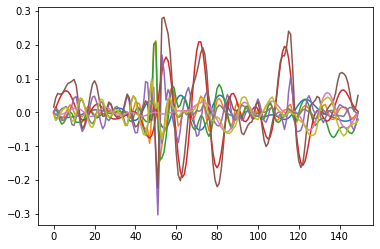

In [ ]:
print(unlabeled_data.shape)
plt.plot(unlabeled_data_for_ts2vec[0],label="unlabeled")
plt.show()

(474, 9, 150)


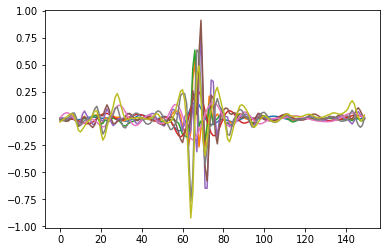

In [ ]:
print(gestures.shape)
plt.plot(gestures_for_ts2vec[0],label="gesture sample")
plt.show()

# unlabeled_dataを使って教師なし表現学習を行う．



In [ ]:
# Train a TS2Vec model
#input_dimsはデータによって変える．
model = TS2Vec(
    input_dims=9,
    device=0,
    output_dims=320
)
loss_log = model.fit(
unlabeled_data_for_ts2vec,
    verbose=True
)

# このノートブックではインスタンスワイズの特徴量を使用する
（overall representation can be obtained by a max pooling over the corresponding timestamps.)

In [ ]:
# Compute instance-level representations for labeled data
test_repr = model.encode(gestures_for_ts2vec, encoding_window='full_series')  # n_instances x output_dims
print(test_repr.shape)

(474, 320)


# T-SNEで２次元まで次元削減してヴィジュアライゼーション．分類をするまでもなくここまで分かれる．

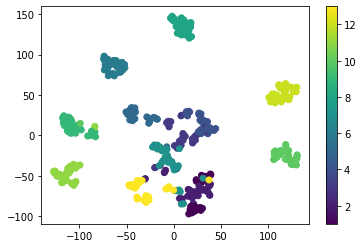

In [ ]:
test_repr_reduced = TSNE(n_components=2, random_state=0, perplexity=5, n_iter=5000).fit_transform(test_repr)
plt.scatter(test_repr_reduced[:, 0], test_repr_reduced[:, 1],c=labels)
#plt.scatter(test_repr_reduced[:, 0], test_repr_reduced[:, 1])
plt.colorbar()

## 本来タイムスタンプレベルの表現を獲得できることにTS2Vecの本領があるらしい．

(474, 150, 320)


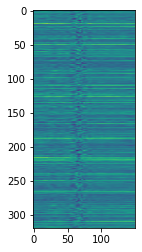

In [ ]:
# Compute timestamp-level representations for labeled data
test_repr_time = model.encode(gestures_for_ts2vec)  # n_instances x output_dims
print(test_repr_time.shape)

plt.imshow(test_repr_time[0].T)
plt.show()